# 5 Job search 2_search and separation

In [3]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /Users/shuhu/anaconda3/lib/python3.7/site-packages (0.4.5)


In [4]:
import numpy as np
from quantecon.distributions import BetaBinomial
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline

# 1 Overview

One unrealistic feature of McCall model:
Every job is permanent.

In this lecture, we extend the McCall model by introducing job separation. 

Once separation enters the picture, the agent comes to view:

1. the loss of a job as a capital loss, and 
2. a spell of unemployment as an investment in searching for an acceptable job.

# 2 The model

The model concerns the life of an infinitely lived worker and

1. the opportunities he has to work at different wages;
2. Exogenous events that destroy his current job;
3. his decision making process while unemployed

The worker can be in one of two states: employed and unemployed.

He wants to maximise
$$
E\sum^{\infty}_{t=0} \beta^t u(Y_t) \tag{1}
$$
The only difference from this to previous McCall model:

We add some flexibility over preference by introducing a utility function $u$.

It satisfies $u' >0$ and $u''<0$.

## Timing and decisions

At the start of a given period:

1. If currently employed, the worker consumes his wage $w$, receiving utility $u(w)$.

   When employed, the agent faces a constant probability $\alpha$ of being unemployed at the end of the period.

2. If currently unemployed, he

   2.1. receives and consumes unemployment compensation $c$ (or / and ?)

   2.2. receives an offer to start work next period at a wage $w'$ drawn from a known distribution $\phi$, but he can either accept or reject the offer:
       a. If he accept the offer, then he enters next period employed with wage $w'$.
       b. If he rejects the offer, then he enters next period unemployed.

(Note: we do not allow for job search while employed, so the individual will not change his job if employed.)

# 3 Solving the model using dynamic programming

Let:

1. $v(w)$ be the total lifetime value accruing to a worker who **enters** the current period employed with wage $w$.
2. $h$ be the total lifetime value accruing to a worker who is **unemployed** this period.

### Remark

Value:the value of the objective function [(1)](#equation-objective)  when the worker makes optimal decisions at all future points in time.

Suppose for now that the worker can calculate the function $v$ and the constant $h$ and use them in his decision making.

Then $v$ and $h$ should satisfy:
$$
v(w) = u(w) + \beta [(1-\alpha)v(w) + \alpha h] \tag{2}
$$
and 
$$
h = u(c) + \beta \sum_{w'} \max{\{ h, v(w') \}} \phi (w') \tag{3}
$$
By the fact that today's tomorrow is tomorrow's today, equations [(2)](#) and [(3)](#) can be interpreted like this:

1. The left-hand sides of equations [(2)](#) and [(3)](#) are the values of a worker in a particular situation today.
2. The right-hand sides of those equations are the discounted (by $\beta$) expected values of the possible situation that worker can be in tomorrow.
3. But tomorrow, the worker can be in only one of the situations whose values today are on the left sides of our two equations.

Equation [(3)](#) incorporates the fact that a currently unemployed worker will maximise this own welfare.

In particular, if his next period wage offer is $w'$, then he will choose to remain unemployed unless $h < v(w')$.

These two equations are the Bellman equations for this model, and they provide enought information to solve out for both $v$ and $h$.

Before discussing the solution, let's make a small extension to the model.


## Stochastic offers

Suppose that unemployed workers only receive an offer with probability $\gamma$.

If our worker does receive an offer, then the wage offer is drawn from $\phi$ as before.

He either accepts or rejects the offer.

Therefore, we have $v$ (same as above) and $h$ (modified) should now satisfy:
$$
v(w) = u(w) + \beta [(1-\alpha)v(w) + \alpha h] \tag{2}
$$
and 
$$
h = u(c) + \beta (1 - \gamma)h +\beta \gamma \sum_{w'} \max{\{ h, v(w') \}} \phi (w') \tag{4}
$$

## Solving the Bellman Equations (Same iterative approach in McCall model)

Steps:

1. make guesses for $h$ and $v$;
2. Plug these guesses into the right-hand sides of [(2)](#) and [(4)](#);
3. update the left-hand sides from this rule and then repeat.

In other words, we will iterate using the rules
$$
v_{n+1}(w') = u(w') + \beta [(1-\alpha)v_n(w') + \alpha h] \tag{5}
$$
and
$$
h_{n+1} = u(c) + \beta (1 - \gamma)h_n +\beta \gamma \sum_{w'} \max{\{ h_n, v_n(w') \}} \phi (w') \tag{6}
$$
starting from some initial conditions $h_0$ and $v_0$.

As before, the system always converges to the true solutions, so the $v$ and $h$ that solve [(2)](#) and [(4)](#).

A proof can be obtained via the Banach contraction mapping theorem.

# 4 Implementation the iterative process

The default utility function is a Constant Relative Risk Aversion (CRRA) utility function.

## Def. Constant Relative Risk Aversion Utility Function
The Constant Relative Risk Aversion (CRRA) utility function is 

$$u(c) =
\begin{cases}
\frac{1}{1- \sigma} c^{1- \sigma} & if \ \sigma > 0, \sigma \neq 1 \\
\ln{c} & if \ \sigma =1 
\end{cases} $$
where the parameter $\sigma$ measures the degree of relative risk aversion that is implicit in the utility function.

In [13]:
# Default CRRA Utility Function

@njit
def u(c, sigma):
    if c > 0:
        return (c**(1 - sigma) - 1) / (1 - sigma)
    else:
        return -10e6
    
# we use "class" to store values of the McCall Model

class McCallModel:       
    def __init__(self,
                alpha = 0.2,  # job separation rate
                beta = 0.98,  # discount factor
                gamma = 0.7,  # job offer rate
                c = 6.0,      # unemployment compensation
                sigma = 2.0,  # degree of relative risk aversion that is implicit in the utility function
                w_vals = None,     #   ? What'None' means? 
                phi_vals = None):
        self.alpha, self.beta, self.gamma, self.c = alpha, beta, gamma, c # Notice 
        self.sigma = sigma
        if w_vals is None: 
            n = 60
            self.w_vals = np.linspace(10, 20, n)
            a, b = 600, 400
            dist = BetaBinomial(n-1, a, b)
            self.phi_vals = dist.pdf()
        else:
            self.w_vals = w_vals
            self.phi_vals = phi_vals


In [14]:
# jitted version of the Bellman equations h and v 

@njit
def Q(v, h, paras):
    alpha, beta, gamma, c, sigma, w_vals, phi_vals = paras
    v_new = np.empty_like(v)
    for i in range(len(w_vals)):
        w = w_vals[i]
        v_new[i] = u(w, sigma) + beta * ((1- alpha) * v[i] + alpha * h)
    h_new = u(c , sigma) + beta * (1 - gamma ) * h + \
                          beta * gamma * np.sum(np.maximum(h, v) * phi_vals)
    return v_new, h_new


Idea of the Approach below: 

Step 1: To iterate until successive iterates are closer together than some small tolerance level.

Step 2: Return the current iterate as an approximate solution.

In [15]:
def solve_model(mcm, tol=1e-5, max_iter = 2000):
    v = np.ones_like(mcm.w_vals)
    h = 1
    i = 0
    error = tol + 1
    while error > tol and i < max_iter:
        v_new, h_new = Q(v, h, (mcm.alpha, mcm.beta, mcm.gamma, mcm.c, mcm.sigma, \
                               mcm.w_vals, mcm.phi_vals)
                        )
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(h_new - h)
        error = max(error_1, error_2)
        v = v_new
        h = h_new
        i += 1
    return v, h


Plot the approximate solutions $v$ and $h$.

The value $v$ is increasing in wage $w$ because higher $w$ generates a higher wage flow conditional on staying employed.

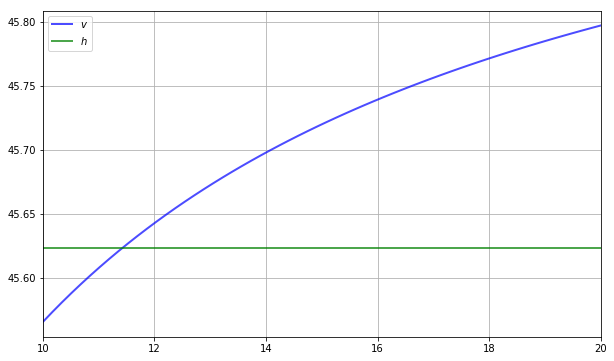

In [16]:
mcm = McCallModel()                 # Assign McCallModel to mcm
v, h = solve_model(mcm)             
fig, ax = plt. subplots(figsize=(10, 6))

ax.plot(mcm.w_vals, v, 'b-', lw = 2, alpha = 0.7, label='$v$')
ax.plot(mcm.w_vals, [h] * len(mcm.w_vals), 'g-', lw = 2, alpha =0.7, label='$h$')
ax.set_xlim(min(mcm.w_vals), max(mcm.w_vals))
ax.legend()
ax.grid()

plt.show()

# 5 The reservation wage (Includes Exercises)

Once $v$ and $h$ are known, the agenet can use them to make decisions in the face of a given wage offer:

1. If $v(w)>h$, then working at wage $w$ is preferred to unemployment;
2. If $v(w)<h$, then remaining unemployed will generate greater lifetime value.

## Def. (The reservation wage)
Suppose that $v$ crosses $h$.
Then since $v$ is increasing, there is unique smallest $w$ in thes et of possible wage such that $v(w)\geq h$.
Denote this wage $\bar{w}$ and call it the reservation wage.


Optiaml behavior for the worker is characterised by $\bar{w}$:

1. If the wage offer $w$ in hand is greater than or equal to $\bar{w}$, then the worker accepts it;
2. If the wage offer $w$ in ahnd is less than $\bar{w}$, then the worker rejects it.

'compute_reservation_wage': An example of McCall Model. It returns the reservation wage associated with a given model. It uses the code 'np.searchsorted' to obtain the first $w$ in the set of possible wages such that $ v(w) > h $. If $v(w)<h$ for all $w$, then the function returns np.inf

In [43]:


def compute_reservation_wage(mcm, return_values=False):
    v, h = solve_model(mcm)
    w_idx = np.searchsorted( v - h, 0) #  How to understand it?
    if w_idx == len(v): # len(): it returns an integer which is the length of the string
        w_bar = np.inf  # 
    else:
        w_bar = mcm.w_vals[w_idx]
        
    if not return_values:
        return w_bar
    else:
        return w_bar, v, h


### Brief introduction about 'np.searchsorted' (I Still feel confused about this function)
Syntax: numpy.searchsorted(a, v, side='left', sorter=None)

Parameters:
1. a: 1-D array_like.
Input array, if sorter is None, then it must be sorted in ascending order, otherwise sorter must be an array of indices that sort it.
2. v: array_like.
Values to insert into $a$.
3. side: {'left', 'right'}, optional.
4. sorter: 1-D array_like, optional.

This function will find the indices into a sorted array $a$ such that, if the corresponding elements in $v$ were inserted before the indices, the order of $a$ would be preserved.

Returns: indices i that satisfy $ a[i-1] < v < a[i] $.


## The reservation wage $\bar w$ vs Parameters (Similar to Comparative analysis?)

We will see how the reservation wage $\bar w$ varies with parameters.

### Question?
We should notice that for the following 4 figures, there are some regions that the reservation wage will not respond to the change in those parameters, why is that?

### The reservation wage $\bar w$ and unemployment compensation $c$

The reservation wage $\bar w$ increases in unemployment compensation $c$, but at a decreasing rate.

Higher unemployment compensation $c$ causes the worker to hold out for higher wages $\bar w$, but the cost of continuing job search is reduced.

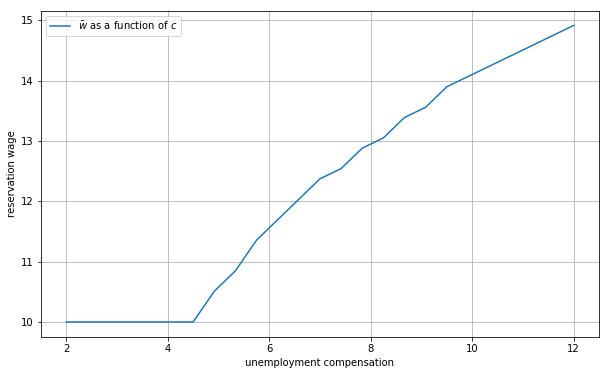

In [44]:
# Reservation wage and unemployment compensation c
grid_size = 25
c_vals = np.linspace(2, 12, grid_size)
w_bar_vals = np.empty_like(c_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize= (10, 6))

for i, c in enumerate(c_vals):
    mcm.c = c
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar
    
ax.set(xlabel = 'unemployment compensation',
      ylabel = 'reservation wage')
ax.plot(c_vals, w_bar_vals, label=r'$\bar w$ as a function of $c$')
ax.grid()
ax.legend()

plt.show()

## Reservation wage and discounting factor $\beta$

Reservation wage $\bar w$ increases in the discounting factor $\beta$, at a constant rate (?).

Intuition behind the figure:
More patient worker will hold out for higher wages.

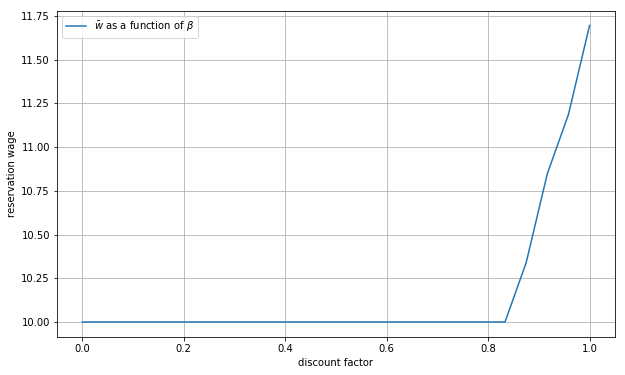

In [45]:
# Reservation wage and discounting beta
grid_size = 25
beta_vals = np.linspace(0, 1, grid_size) 
w_bar_vals = np.empty_like(beta_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize= (10, 6))

for i, beta in enumerate(beta_vals):
    mcm.beta = beta
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar
    
ax.set(xlabel = 'discount factor',
      ylabel = 'reservation wage')
ax.plot(beta_vals, w_bar_vals, label=r'$\bar w$ as a function of $\beta$')
ax.grid()
ax.legend()

plt.show()

## Reservation wage $\bar w$ and job separation rate $\alpha$

The reservation wage $\bar w$ is decreasing in the job separation rate $\alpha$, at a decreasing rate (?).

Intuition behind: 
Higher job seperation rate $\alpha$: a greater chance that a worker will face termination in each period once employed.
If the separation rate is high, then the benefit of holding out for a higher wage falls, and the worker's reservation wage would falls down.

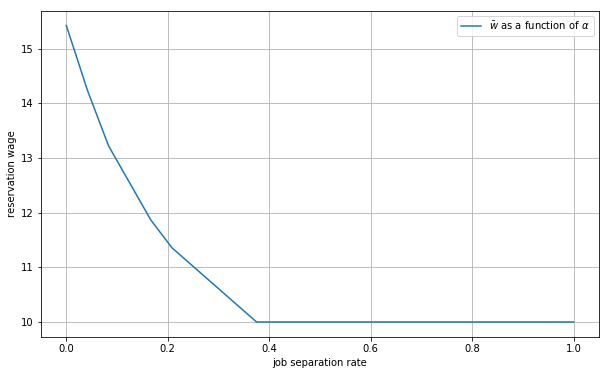

In [46]:
# Reservation wage and job separation rate alpha
grid_size = 25
alpha_vals = np.linspace(0, 1, grid_size)
w_bar_vals = np.empty_like(alpha_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize= (10, 6))

for i, alpha in enumerate(alpha_vals):
    mcm.alpha = alpha
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar
    
ax.set(xlabel = 'job separation rate',
      ylabel = 'reservation wage')
ax.plot(alpha_vals, w_bar_vals, label=r'$\bar w$ as a function of $\alpha$')
ax.grid()
ax.legend()

plt.show()

## The reservation wage $\bar w$ and job offer rate $\gamma$

The reservation wage $\bar w$ is increasing in the job offer rate $\gamma$, but the rate is nonconstant.

Intuition behind:
Higher job offer rate $\gamma$ implies a more favorable job search environment.
So workers are less willing to accept lower offers in this environment.


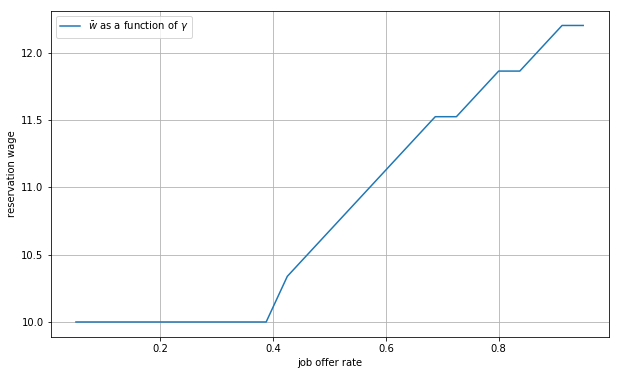

In [47]:
# reservation wage and job offer rate gamma
grid_size = 25
gamma_vals = np.linspace(0.05, 0.95, grid_size)
w_bar_vals = np.empty_like(gamma_vals)

mcm = McCallModel()

fig, ax = plt.subplots(figsize= (10, 6))

for i, gamma in enumerate(gamma_vals):
    mcm.gamma = gamma
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar
    
ax.set(xlabel = 'job offer rate',
      ylabel = 'reservation wage')
ax.plot(gamma_vals, w_bar_vals, label=r'$\bar w$ as a function of $\gamma$')
ax.grid()
ax.legend()

plt.show()